7.1 투표 기반 분류기
--------------------
더 좋은 분류기를 만드는 매우 간단한 방법 : 각 분류기의 예측을 모아서 가장 많이 선택된 클래스를 예측하기

직접 투표 분류기 : 다수결 투표로 정해지는 분류기

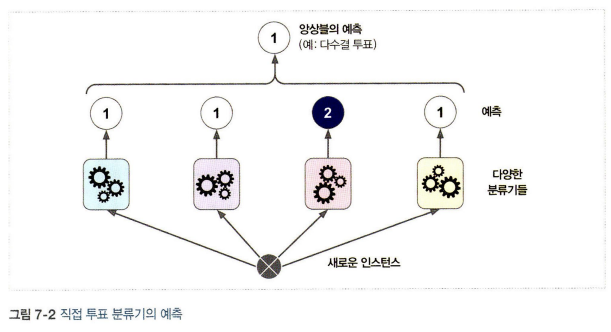

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# import package
import numpy as np
import os

In [ ]:
# 5장에서 소개한 moons dataset 불러오기
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
X,y = make_moons(n_samples=100, noise=0.15)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
# 여러 분류기를 조합하여 사이킷런의 투표 기반 분류기를 만들고 훈련시키기
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators = [('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)], voting='hard')
voting_clf.fit(X_train, y_train)

In [ ]:
#각 분류기의 테스트셋 정확도 확인
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
  clf.fit(X_train, y_train)
  y_pred=clf.predict(X_test)
  print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

성능 : 투표 기반 분류기 > 다른 개별 분류기

간접 투표 : 모든 분류기가 클래스의 확률을 예측할 수 있으면 개별 분류기의 예측을 평균을 내어 확률이 가장 높은 클래스를 예측할 수 있음
- 직접 투표 방식보다 성능 높음

7.2 배깅과 페이스팅
---------------------
배깅 : 훈련 세트에서 중복을 허용하여 샘플링하는 방식

페이스팅 : 중복을 허용하지 않고 샘플링하는 방식

-
- 모든 예측기가 훈련을 마치면 앙상블은 모든 예측기의 예측을 모아서 새로운 샘플에 대한 예측을 만듦

- 수집 함수는 전형적으로 분류일 때는 통계적 최빈값이고 회귀에 대해서는 평균을 계산함

- 개별 예측기는 원본 훈련 세트로 훈련시킨 것보다 훨씬 크게 편향되어 있지만 수집 함수를 통과하면 편향과 분산이 모두 감소함

- 일반적으로 앙상블의 결과는 원본 데이터셋으로 하나의 예측기를 훈련시킬 때와 비교해 편향은 비슷하지만 분산은 줄어듦

7.2.1 사이킷런의 배깅과 페이스팅
------------------------------------

In [ ]:
#결정 트리 분류기 500개의 앙상블을 훈련시키는 코드
#각 분류기는 훈련 세트에서 중복을 허용하여 무작위로 선택된 100개의 샘플로 훈련됨
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, max_samples=50, bootstrap=True, n_jobs=-1)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

BaggingClassifier : 기반이 되는 분류기가 결정 트리 분류기처럼 클래스 확률을 추정할 수 있으면 직접 투표 대신 자동으로 간접 투표 방식을 사용함

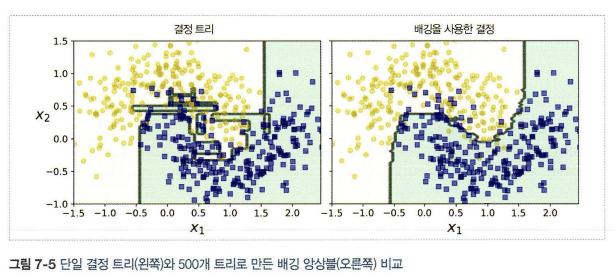

부트스트래핑 : 각 예측기가 학습하는 서브셋에 다양성을 증가시키므로 배깅이 페이스팅보다 편향이 조금 더 높음

- 하지만 다양성을 추가한다는 것은 예측기들의 상관관계를 줄이므로 앙상블의 분산을 감소시킴

- 전반적으로 배깅이 더 나은 모델을 만들기 때문에 일반적으로 더 선호함

- 하지만 CPU 파워와 시간적 여유가 있다면 교차 검증으로 배깅과 페이스팅을 모두 평가해서 나은 쪽을 선택하는 것이 나음

7.2.2 obb 평가
-------------------

In [ ]:
#oob 평가
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)

#평가 점수 결과
bag_clf.oob_score_

In [ ]:
#테스트 세트에서 정확도 (실제 정확도)
from sklearn.metrics import accuracy_score

y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

In [ ]:
#obb 샘플에 대한 결정 함수의 값 확인 _ 결정함수는 각 훈련 샘플의 클래스 확률을 반환
bag_clf.oob_decision_function_

7.3 랜덤 패치와 랜덤 스페이스
-----------------------------------
랜덤 패치 방식 : 훈련 특성과 샘플을 모두 샘플링하는 것

랜덤 서브스페이스 방식 : 훈련 샘플을 모두 사용하고 특성은 샘플링하는 것

-> 특성 샘플링은 더 다양한 예측기를 만들어 편향을 늘리는 대신 분산을 낮춤

7.4 랜덤 포레스트
----------------------

In [ ]:
#500개 트리로 이뤄진 랜덤포레스트 분류기를 여러 CPU 코어에서 훈련시키는 코드
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [ ]:
#BaggingClassifier을 RandomforestClassifier와 비슷하게 구현
bag_clf=BaggingClassifier(DecisionTreeClassifier(max_features='auto', max_leaf_nodes=16),
                          n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1)

7.4.1 엑스트라 트리
-------------------
익스트림 랜덤 트리 (엑스트라 트리) : 극단적으로 무작위한 트리의 랜덤 포레스트. 편향이 늘어나지만 분산을 낮추게 됨. 랜덤포레스트보다 속도가 훨씬 빠름

7.4.2 특성 중요도
-------------------
랜덤 포레스트의 장점 : 특성의 상대적 중요도를 측정하기 쉬움

사이킷런 : 어떤 특성을 사용한 노드가 평균적으로 불순도를 얼마나 감소시키는지 확인하여 특성의 중요도를 측정함. 즉, 가중치 평균이며 각 노드의 가중치는 연관된 훈련된 샘플수와 같음

In [ ]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris['data'], iris['target'])
for name, score in zip(iris['feature_names'], rnd_clf.feature_importances_):
  print(name, score)

7.5 부스팅
--------------
부스팅 : 약한 학습기를 여러개 연결하여 강한 학습기를 만드는 앙상블 방법

부스팅의 아이디어 : 앞의 모델을 보완해나가면서 일련의 예측기를 학습시키는 것

7.5.1 에이다부스트
------------------------
사용 방식 : 이전 모델이 과소적합했던 훈련 샘플의 가중치를 더 높임으로써 새로운 예측기는 학습하기 어려운 샘플에 점점 맞춰지게 됨

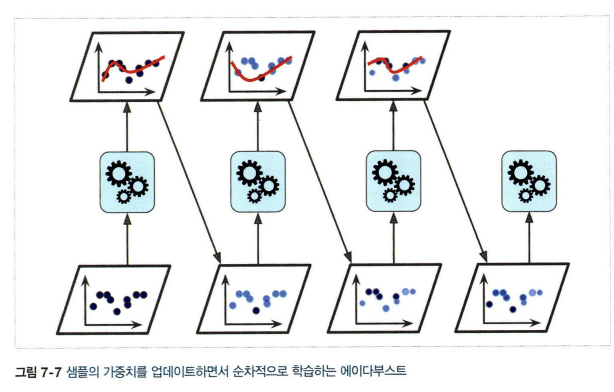

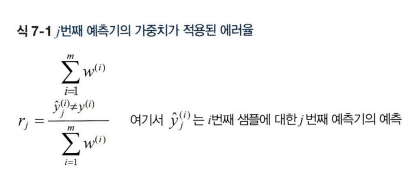

- 예측기가 정확할수록 가중치가 높아짐.
- 만약 무작위로 예측하는 정도라면 가중치가 0에 가까워지고 그보다 나쁘면 가중치는 음수가 됨

에이다부스트 알고리즘 : 샘플의 가중치를 업데이트함

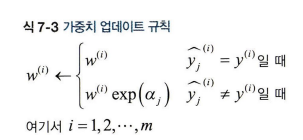

In [ ]:
#AdaBoostClassifier의 기본 추정기
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

7.5.2 그래디언트 부스팅
--------------------------
그래디언트 부스팅
- 앙상블에 이전까지의 오차를 보정하도록 예측기를 순차적으로 추가함.
- 에이다부스트와는 달리 이전 예측기가 만든 잔여 오차에 새로운 예측기를 학습시킴

In [ ]:
# 데이터 저장
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [ ]:
#DT를 훈련세트에 학습
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=1)
tree_reg1.fit(X, y)

In [ ]:
#첫번째 예측기에서 생긴 잔여 오차에 두번째 DT를 훈련
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=1)
tree_reg2.fit(X, y2)

In [ ]:
#두번째 예측기가 만든 잔여 오차에 세번째 회귀 모델을 훈련
y3 = y - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

In [ ]:
# 테스트셋 생성
X_new = np.array([[0.8]])

In [ ]:
#새로운 샘플에 대한 예측 -> 모든 트리의 예측 더하기
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [ ]:
#이전에 만든 것과 같은 앙상블을 만드는 코드
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=1)
gbrt.fit(X, y)

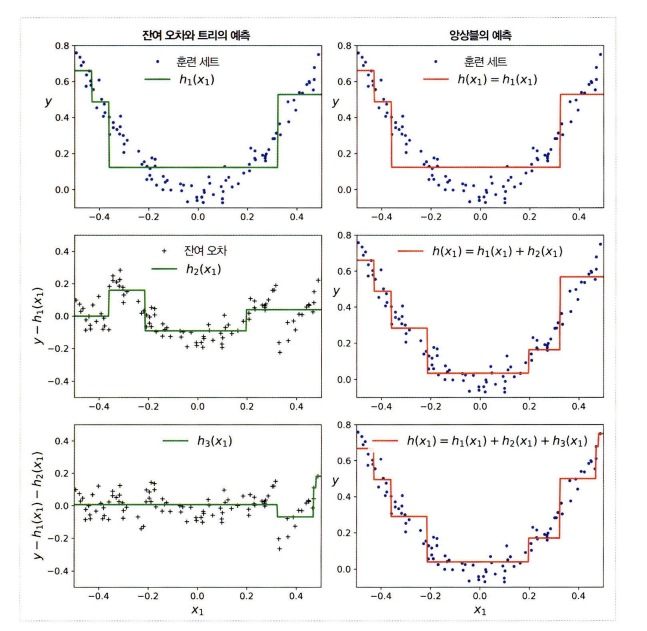

왼쪽 열 : DT의 예측 / 오른쪽 열 : 앙상블의 예측

첫번째 행 : 앙상블의 트리가 하나만 있어서 첫번째 트리의 예측과 완전히 같음

두번째 행 : 새로운 트리가 첫 번째 트리의 잔여 오차에 대해 학습됨. 오른쪽의 앙상블 예측이 두 개의 트리 예측의 합과 같은 것을 확인

세번째 행 : 또 다른 트리가 두번째 트리의 잔여 오차에 훈련됨. 트리가 앙상블에 추가될수록 앙상블의 예측이 점차 좋아짐

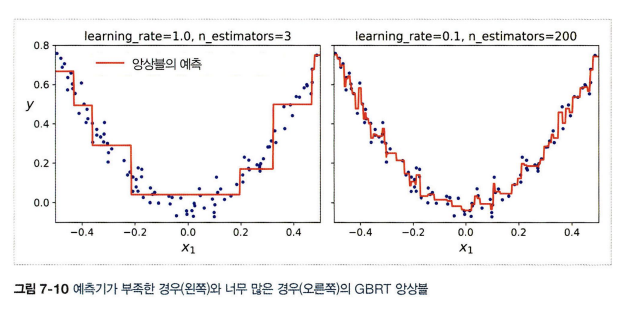

축소 (규제방식 중 하나)
- learning_rate를 낮게 설정 -> 앙상블을 훈련 세트에 학습시키기 위해 많은 트리가 필요하지만 일반적으로 예측의 성능은 좋아짐

왼쪽 : 훈련 세트를 학습하기에는 트리가 불충분

오른쪽 : 트리가 너무 많아 훈련 세트에 과대적합

In [ ]:
#120개의 트리로 GBRT 앙상블 훈련시키고 최적의 트리수 찾기
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=1)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=1)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

#최적의 트리 수를 사용해 새로운 GBRT 앙상블 훈련
gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=1)
gbrt_best.fit(X_train, y_train)


In [ ]:
#연속해서 다섯번의 반복동안 검증 오차가 향상되지 않으면 훈련 멈춤
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=1)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # 조기 종료

In [ ]:
#xgboost
import xgboost

xgb_reg = xgboost.XGBRegressor(random_state=1)
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)

In [ ]:
#xgboost -> 자동 조기 종료 기능
xgb_reg.fit(X_train, y_train,
            eval_set=[(X_val, y_val)], early_stopping_rounds=2)
y_pred = xgb_reg.predict(X_val)

7.6 스태킹
--------------
블렌더를 학습시키는 일반적인 방법 : 홀드아웃 세트를 사용하는 것

스태킹 작동방식
1. 훈련 세트를 두개의 서브셋으로 나눈다. 첫번째 서브셋은 첫번째 레이어의 예측을 훈련시키기 위해 사용됨
2. 첫번째 레이어의 예측기를 사용해 두번째 (홀드아웃)세트에 대한 예측 만듦. 예측기들이 훈련하는 동안 이 샘플들을 전혀 보지 못했기 때문에 이때 만들어진 예측은 새로운 것임

-> 블렌더만의 레이어가 만들어지고, 학습과정 반복하면 레이어를 차례로 실행해서 새로운 샘플에 대한 예측을 만들 수 있음

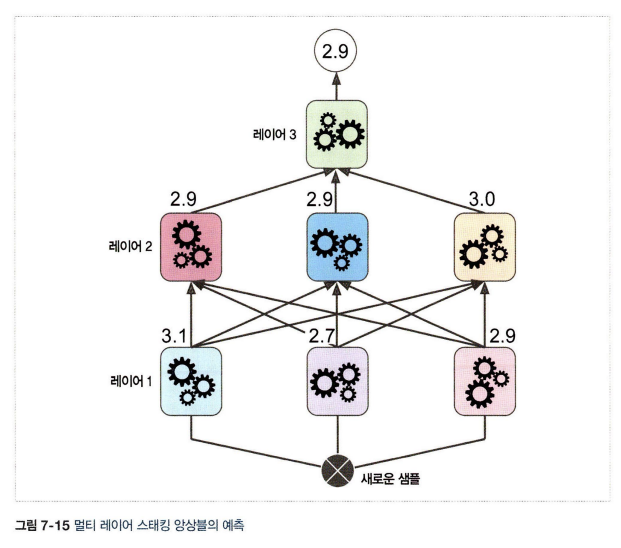